In [8]:
import torch_geometric_temporal
print(torch_geometric_temporal.__version__)


0.54.0


In [9]:
import sys
import torch
if not torch.cuda.is_available():
    print("CUDA is not available. Exiting.")
    sys.exit(1)
else:
    #print information about the GPU
    print("CUDA is available. Using GPU:")
    print(torch.cuda.get_device_name(0))
    print("CUDA version:", torch.version.cuda)
    print("PyTorch version:", torch.__version__)
    print("Number of GPUs:", torch.cuda.device_count())
    print("Current device:", torch.cuda.current_device())

CUDA is available. Using GPU:
NVIDIA GeForce GTX 1050 Ti
CUDA version: 12.1
PyTorch version: 2.5.1+cu121
Number of GPUs: 1
Current device: 0


In [10]:
import torch
import torch.nn.functional as F
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from torch_geometric_temporal.signal import StaticGraphTemporalSignal
from torch_geometric_temporal.nn.recurrent import DCRNN
import matplotlib.pyplot as plt

# 1. Đọc và tiền xử lý dữ liệu
df = pd.read_csv('traffic.csv')
df = df[df['Junction'].isin([1,2,3])]  # Lọc junction 1-3
df['DateTime'] = pd.to_datetime(df['DateTime'])
df = df.sort_values('DateTime')

# Pivot để mỗi hàng là một timestamp, cột là junction 1,2,3
df_pivot = df.pivot(index='DateTime', columns='Junction', values='Vehicles')

# Xử lý missing values: forward fill rồi backward fill, cuối cùng fill 0 nếu còn NaN
df_pivot = df_pivot.fillna(method='ffill').fillna(method='bfill').fillna(0)

# Chuyển sang numpy array
data = df_pivot.values  # shape (num_timestamps, 3)

# --- FIX: Split data BEFORE scaling ---
n_samples = data.shape[0]
train_size_idx = int(n_samples * 0.7)
val_size_idx = int(n_samples * 0.1)
test_size_idx = n_samples - train_size_idx - val_size_idx

train_data_unscaled = data[:train_size_idx]
val_data_unscaled = data[train_size_idx : train_size_idx + val_size_idx]
test_data_unscaled = data[train_size_idx + val_size_idx :]
# --- ADDED: Export train/val/test splits to CSV ---
# Use the DateTime index from df_pivot for the CSV files
df_train = df_pivot.iloc[:train_size_idx]
df_val = df_pivot.iloc[train_size_idx : train_size_idx + val_size_idx]
df_test = df_pivot.iloc[train_size_idx + val_size_idx :]

df_train.to_csv('GNN_train.csv')
df_val.to_csv('GNN_val.csv')
df_test.to_csv('GNN_test.csv')
print("Train, validation, and test data splits exported to GNN_train.csv, GNN_val.csv, and GNN_test.csv")
# Chuẩn hóa dữ liệu: Fit scaler ONLY on training data
scaler = MinMaxScaler()
train_data_scaled = scaler.fit_transform(train_data_unscaled)

# Transform validation and test data using the FITTED scaler
val_data_scaled = scaler.transform(val_data_unscaled)
test_data_scaled = scaler.transform(test_data_unscaled)

# Reshape cho phù hợp với PyG Temporal: [samples, nodes, features]
# X and y will be the scaled data for each respective set
X_train = train_data_scaled.reshape(-1, 3, 1)
y_train = train_data_scaled.reshape(-1, 3, 1) # Assuming auto-regressive setup

X_val = val_data_scaled.reshape(-1, 3, 1)
y_val = val_data_scaled.reshape(-1, 3, 1)

X_test = test_data_scaled.reshape(-1, 3, 1)
y_test = test_data_scaled.reshape(-1, 3, 1)

# 2. Xây dựng đồ thị dựa trên correlation matrix của TEST SET
train_corr = pd.DataFrame(train_data_unscaled, columns=[1, 2, 3]).corr().values
np.fill_diagonal(train_corr, 0)
adj_matrix = train_corr
print("Adjacency matrix based on training data correlation:\n", adj_matrix)
# 3. Tạo StaticGraphTemporalSignal
edge_index = np.array([[i, j] for i in range(3) for j in range(3) if i != j]).T
edge_weight = adj_matrix[edge_index[0], edge_index[1]]

def create_temporal_graph_dataset(data, lags=12, horizon=1):
    """
    data: numpy array of shape (num_timesteps, num_nodes)
    lags: number of past steps to use as features
    horizon: number of steps ahead to predict (default 1)
    Returns: list of StaticGraphTemporalSignal objects (one per sample)
    """
    num_samples = data.shape[0] - lags - horizon + 1
    features_list = []
    targets_list = []
    for i in range(num_samples):
        # Features: lags timesteps, shape (lags, num_nodes)
        features = data[i : i + lags]
        # Target: next 'horizon' timesteps, shape (horizon, num_nodes)
        target = data[i + lags : i + lags + horizon]
        features_list.append(features.T.astype(np.float32))  # shape (num_nodes, lags)
        targets_list.append(target.T.astype(np.float32))      # shape (num_nodes, horizon)
    return features_list, targets_list

# Example usage:
lags = 24  # e.g., use past 12 hours
horizon = 1  # predict next hour

# Split indices for time series (chronological, no leakage)
n_total = data.shape[0] - lags - horizon + 1
n_train = int(n_total * 0.7)
n_val = int(n_total * 0.1)
n_test = n_total - n_train - n_val

# Prepare features/targets for each split
features, targets = create_temporal_graph_dataset(data, lags=lags, horizon=horizon)
features = np.array(features)  # shape (samples, num_nodes, lags)
targets = np.array(targets)    # shape (samples, num_nodes, horizon)

X_train, y_train = features[:n_train], targets[:n_train]
X_val, y_val = features[n_train:n_train+n_val], targets[n_train:n_train+n_val]
X_test, y_test = features[n_train+n_val:], targets[n_train+n_val:]

# Build edge_index and edge_weight as before
edge_index = np.array([[i, j] for i in range(3) for j in range(3) if i != j]).T
edge_weight = adj_matrix[edge_index[0], edge_index[1]]

from torch_geometric_temporal.signal import StaticGraphTemporalSignal

def build_pyg_temporal_dataset(X, y):
    # X: (samples, num_nodes, lags), y: (samples, num_nodes, horizon)
    dataset = []
    for i in range(X.shape[0]):
        dataset.append(
            StaticGraphTemporalSignal(
                edge_index=torch.tensor(edge_index, dtype=torch.long),
                edge_weight=torch.tensor(edge_weight, dtype=torch.float),
                features=[X[i]],  # list of shape (num_nodes, lags)
                targets=[y[i]]    # list of shape (num_nodes, horizon)
            )
        )
    return dataset

train_dataset = build_pyg_temporal_dataset(X_train, y_train)
val_dataset = build_pyg_temporal_dataset(X_val, y_val)
test_dataset = build_pyg_temporal_dataset(X_test, y_test)

import torch
import torch.nn as nn
import torch.nn.functional as F

# --- DSTGRNN Implementation ---
class DSTGRNNCell(nn.Module):
    def __init__(self, node_features, hidden_dim, num_nodes):
        super().__init__()
        self.node_features = node_features
        self.hidden_dim = hidden_dim
        self.num_nodes = num_nodes

        self.adj_mlp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_nodes)
        )
        self.gru = nn.GRUCell(node_features + hidden_dim, hidden_dim)

    def forward(self, x, h):
        # x: [num_nodes, node_features]
        # h: [num_nodes, hidden_dim]
        adj_logits = self.adj_mlp(h)  # [num_nodes, num_nodes]
        adj = torch.sigmoid(adj_logits)
        adj = adj / (adj.sum(dim=1, keepdim=True) + 1e-8)
        agg = torch.matmul(adj, h)  # [num_nodes, hidden_dim]
        gru_input = torch.cat([x, agg], dim=-1)  # [num_nodes, node_features + hidden_dim]
        h_new = self.gru(gru_input, h)
        return h_new, adj

class DSTGRNN(nn.Module):
    def __init__(self, node_features, hidden_dim, num_nodes, out_dim=1):
        super().__init__()
        self.cell = DSTGRNNCell(node_features, hidden_dim, num_nodes)
        self.linear = nn.Linear(hidden_dim, out_dim)

    def forward(self, x_seq):
        # x_seq: [num_nodes, lags, node_features]
        num_nodes, lags, node_features = x_seq.shape
        h = torch.zeros(num_nodes, self.cell.hidden_dim, device=x_seq.device)
        for t in range(lags):
            x_t = x_seq[:, t, :]  # [num_nodes, node_features]
            h, adj = self.cell(x_t, h)
        out = self.linear(F.relu(h))  # [num_nodes, out_dim]
        return out

class RecurrentGNN(torch.nn.Module):
    def __init__(self, node_features=1, filters=32, num_nodes=3):
        super().__init__()
        self.recurrent = DSTGRNN(node_features, filters, num_nodes)
    def forward(self, x_seq):
        return self.recurrent(x_seq)

# --- Device and Model Setup ---
import sys
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
model = RecurrentGNN(node_features=1, filters=32, num_nodes=3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()

# --- Training Loop ---
epochs = 48
patience = 12
patience_counter = 0
best_val_loss = float('inf')
best_model_state = None

batch_size = 64

def batchify(dataset, batch_size):
    return [dataset[i:i+batch_size] for i in range(0, len(dataset), batch_size)]

batched_train = batchify(train_dataset, batch_size)
batched_val = batchify(val_dataset, batch_size)

for epoch in range(epochs):
    model.train()
    total_loss = 0
    num_train_snapshots = 0
    for batch in batched_train:
        optimizer.zero_grad()
        # Prepare batch: [B, num_nodes, lags] -> [B, num_nodes, lags, 1]
        x_seqs = torch.stack([torch.tensor(s.features[0], dtype=torch.float32, device=device).unsqueeze(-1) for s in batch])  # [B, num_nodes, lags, 1]
        y_trues = torch.stack([torch.tensor(s.targets[0], dtype=torch.float32, device=device).squeeze(-1) for s in batch])    # [B, num_nodes]
        batch_loss = 0
        for i in range(x_seqs.shape[0]):
            # [num_nodes, lags, 1]
            x_seq = x_seqs[i].permute(0, 1, 2)  # [num_nodes, lags, 1]
            y_true = y_trues[i]                 # [num_nodes]
            y_pred = model(x_seq).squeeze(-1)   # [num_nodes]
            batch_loss += criterion(y_pred, y_true)
        batch_loss = batch_loss / x_seqs.shape[0]
        batch_loss.backward()
        optimizer.step()
        total_loss += batch_loss.item() * x_seqs.shape[0]
        num_train_snapshots += x_seqs.shape[0]

    avg_train_loss = total_loss / num_train_snapshots if num_train_snapshots > 0 else 0

    # Validation
    model.eval()
    val_loss = 0
    num_val_snapshots = 0
    with torch.no_grad():
        for batch in batched_val:
            x_seqs = torch.stack([torch.tensor(s.features[0], dtype=torch.float32, device=device).unsqueeze(-1) for s in batch])
            y_trues = torch.stack([torch.tensor(s.targets[0], dtype=torch.float32, device=device).squeeze(-1) for s in batch])
            batch_loss = 0
            for i in range(x_seqs.shape[0]):
                x_seq = x_seqs[i].permute(0, 1, 2)
                y_true = y_trues[i]
                y_pred = model(x_seq).squeeze(-1)
                batch_loss += criterion(y_pred, y_true)
            batch_loss = batch_loss / x_seqs.shape[0]
            val_loss += batch_loss.item() * x_seqs.shape[0]
            num_val_snapshots += x_seqs.shape[0]

    avg_val_loss = val_loss / num_val_snapshots if num_val_snapshots > 0 else 0

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.6f} - Val Loss: {avg_val_loss:.6f}")

    # Early stopping logic
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        best_model_state = model.state_dict()
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f"Early stopping triggered after {epoch+1} epochs. Best validation loss: {best_val_loss:.6f}")
        if best_model_state is not None:
            model.load_state_dict(best_model_state)
        break

# Load the best model state
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print("Loaded best model state from validation.")

C:\Users\PLN\AppData\Local\Temp\ipykernel_19964\380972190.py:20: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_pivot = df_pivot.fillna(method='ffill').fillna(method='bfill').fillna(0)


Train, validation, and test data splits exported to GNN_train.csv, GNN_val.csv, and GNN_test.csv
Adjacency matrix based on training data correlation:
 [[0.         0.79425994 0.47142958]
 [0.79425994 0.         0.37592124]
 [0.47142958 0.37592124 0.        ]]
Using device: cuda
Epoch 1/48 - Train Loss: 309.866063 - Val Loss: 668.627941
Epoch 2/48 - Train Loss: 127.034010 - Val Loss: 353.507371
Epoch 3/48 - Train Loss: 57.526585 - Val Loss: 234.566930
Epoch 4/48 - Train Loss: 38.419349 - Val Loss: 174.083672
Epoch 5/48 - Train Loss: 28.679102 - Val Loss: 136.784041
Epoch 6/48 - Train Loss: 22.852997 - Val Loss: 105.953955
Epoch 7/48 - Train Loss: 23.156705 - Val Loss: 106.240848
Epoch 8/48 - Train Loss: 19.918086 - Val Loss: 77.716013
Epoch 9/48 - Train Loss: 18.727856 - Val Loss: 68.892211
Epoch 10/48 - Train Loss: 17.979094 - Val Loss: 67.003634
Epoch 11/48 - Train Loss: 18.864015 - Val Loss: 73.734691
Epoch 12/48 - Train Loss: 18.531336 - Val Loss: 69.650464
Epoch 13/48 - Train Loss:

In [11]:
# Load the best model state
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print("Loaded best model state from validation.")
# Save model to file (update filename to reflect DSTGRNN)
torch.save(model.state_dict(), 'dstgrnn_model.pth')

Loaded best model state from validation.


Test Loss: 57.707743


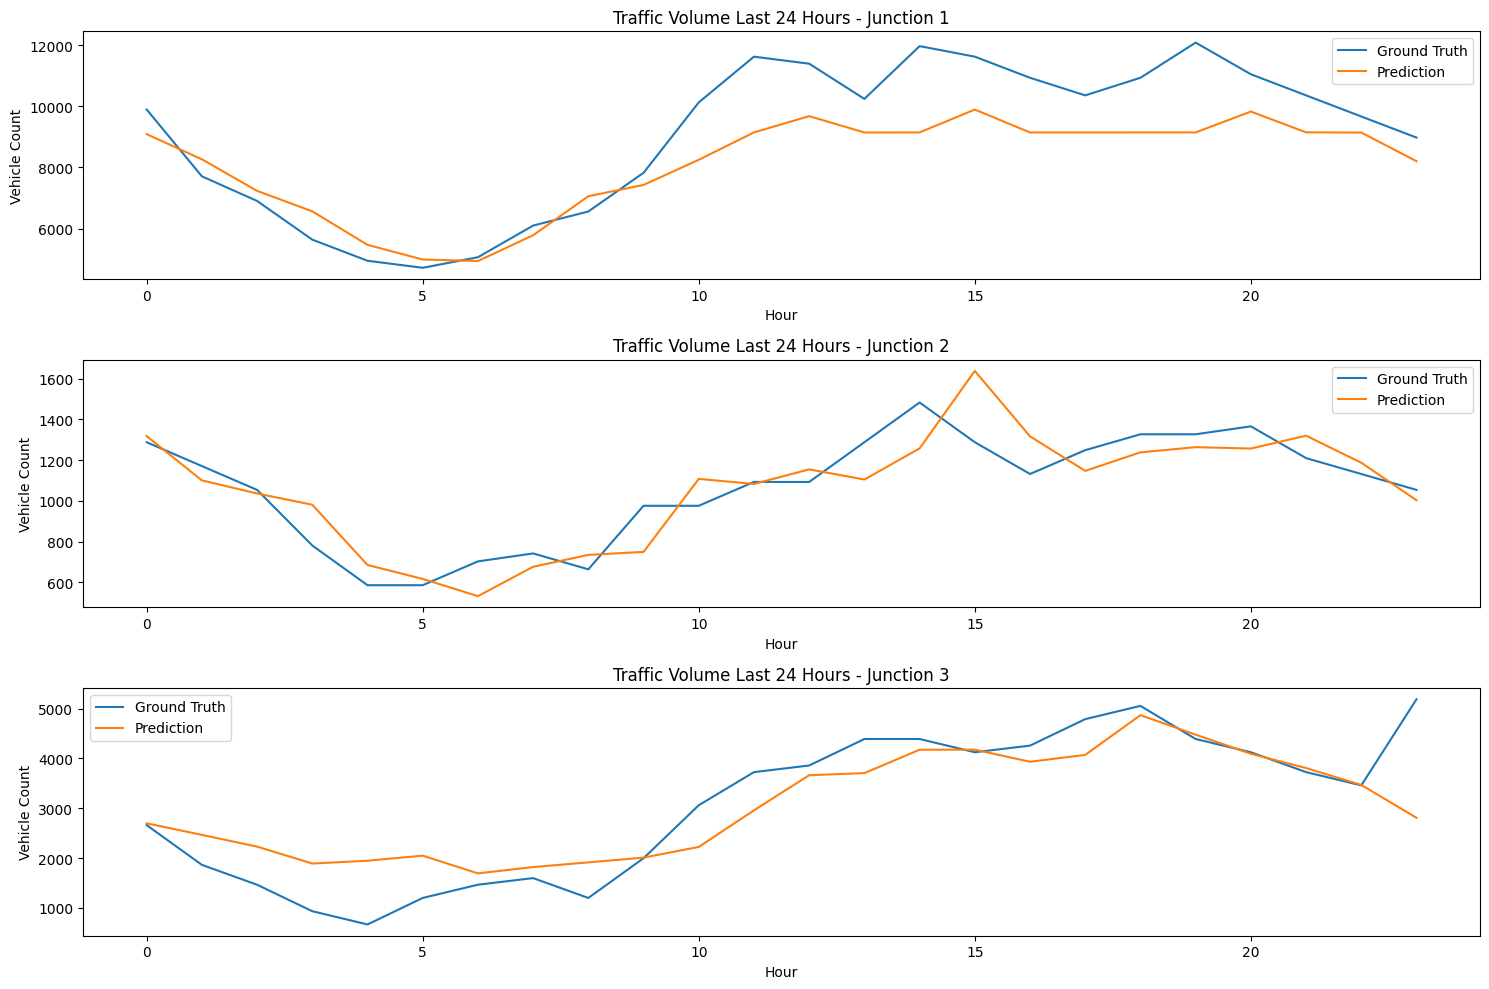

Model saved as traffic_gnn_dstgrnn.pth


In [12]:
# 6. Đánh giá trên test set (DSTGRNN version)
model.eval()
test_loss = 0
num_test_snapshots = 0  # Initialize counter for test snapshots
with torch.no_grad():
    for snapshot in test_dataset:
        x_seq = torch.tensor(snapshot.features[0], dtype=torch.float32, device=device).unsqueeze(-1)  # [num_nodes, lags, 1]
        y_true = torch.tensor(snapshot.targets[0], dtype=torch.float32, device=device).squeeze(-1)    # [num_nodes]
        y_pred = model(x_seq).squeeze(-1)  # [num_nodes]
        test_loss += criterion(y_pred, y_true).item()
        num_test_snapshots += 1

if num_test_snapshots > 0:
    avg_test_loss = test_loss / num_test_snapshots
else:
    avg_test_loss = 0  # Avoid division by zero
print(f"Test Loss: {avg_test_loss:.6f}")

# 7. Vẽ biểu đồ dự đoán 24h cuối test set (DSTGRNN version)
preds = []
truths = []
with torch.no_grad():
    for snapshot in list(test_dataset)[-24:]:
        x_seq = torch.tensor(snapshot.features[0], dtype=torch.float32, device=device).unsqueeze(-1)  # [num_nodes, lags, 1]
        y_true = torch.tensor(snapshot.targets[0], dtype=torch.float32, device=device).squeeze(-1)    # [num_nodes]
        y_pred = model(x_seq).squeeze(-1)  # [num_nodes]
        preds.append(y_pred.cpu().numpy().squeeze())
        truths.append(y_true.cpu().numpy().squeeze())

preds = np.array(preds)  # shape (24, 3)
truths = np.array(truths)

# Inverse scale về giá trị gốc
preds_inv = scaler.inverse_transform(preds)
truths_inv = scaler.inverse_transform(truths)

hours = np.arange(24)
junctions = ['Junction 1', 'Junction 2', 'Junction 3']

plt.figure(figsize=(15, 10))
for i in range(3):
    plt.subplot(3, 1, i+1)
    plt.plot(hours, truths_inv[:, i], label='Ground Truth')
    plt.plot(hours, preds_inv[:, i], label='Prediction')
    plt.title(f'Traffic Volume Last 24 Hours - {junctions[i]}')
    plt.xlabel('Hour')
    plt.ylabel('Vehicle Count')
    plt.legend()
plt.tight_layout()
plt.show()

# 8. Lưu mô hình
torch.save(model.state_dict(), 'traffic_gnn_dstgrnn.pth')
print("Model saved as traffic_gnn_dstgrnn.pth")

In [13]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

junctions = ['Junction 1', 'Junction 2', 'Junction 3']
print(f"{'Junction':<12} {'RMSE':>10} {'MAE':>10} {'R2':>10}")
junctions_rmse = []
junctions_mae = []
junctions_r2 = []

for i, name in enumerate(junctions):
    # Ensure 1D arrays for metrics
    y_true = truths_inv[:, i].reshape(-1)
    y_pred = preds_inv[:, i].reshape(-1)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    junctions_rmse.append(rmse)
    junctions_mae.append(mae)
    junctions_r2.append(r2)
    print(f"{name:<12} {rmse:10.2f} {mae:10.2f} {r2:10.2f}")

Junction           RMSE        MAE         R2
Junction 1      1411.38    1162.53       0.66
Junction 2       138.57     112.79       0.71
Junction 3       736.57     509.79       0.74


Junction 1 - RMSE: 1675.28, MAE: 1218.94, R2: 0.72
Junction 2 - RMSE: 171.86, MAE: 127.89, R2: 0.79
Junction 3 - RMSE: 606.77, MAE: 454.70, R2: 0.75


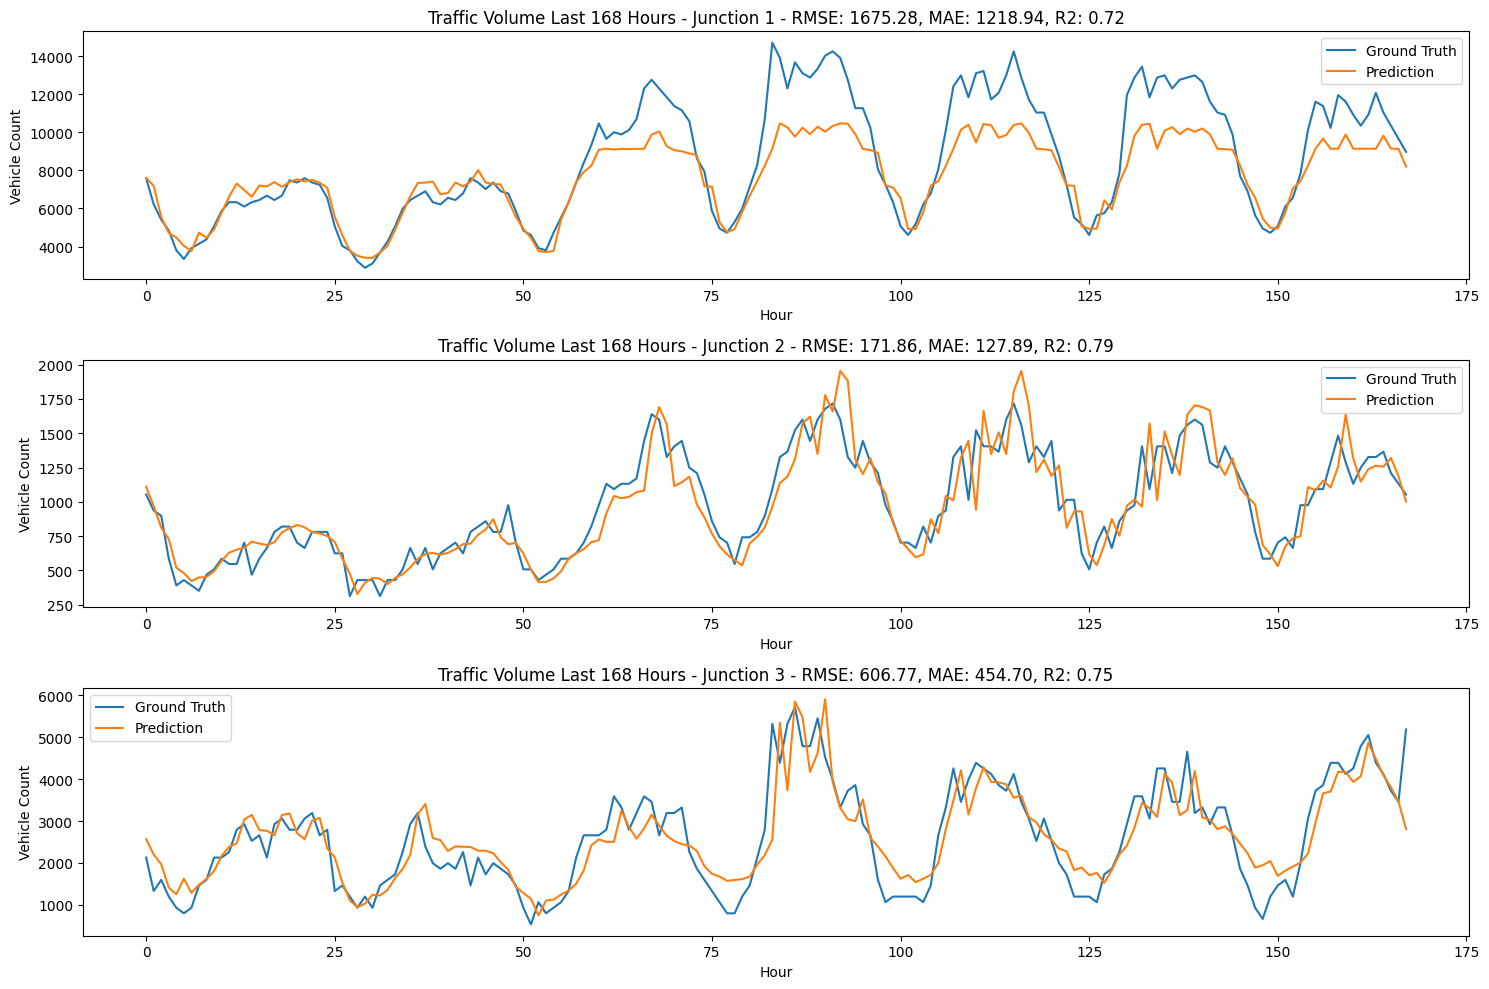

In [14]:
# Plot 1 last week of test set (168 hours) for DSTGRNN
preds = []
truths = []
with torch.no_grad():
    for snapshot in list(test_dataset)[-168:]:
        x_seq = torch.tensor(snapshot.features[0], dtype=torch.float32, device=device).unsqueeze(-1)  # [num_nodes, lags, 1]
        y_true = torch.tensor(snapshot.targets[0], dtype=torch.float32, device=device).squeeze(-1)    # [num_nodes]
        y_pred = model(x_seq).squeeze(-1)  # [num_nodes]
        preds.append(y_pred.cpu().numpy().squeeze())
        truths.append(y_true.cpu().numpy().squeeze())
preds = np.array(preds)  # shape (168, 3)
truths = np.array(truths)
# Inverse scale về giá trị gốc
preds_inv = scaler.inverse_transform(preds)
truths_inv = scaler.inverse_transform(truths)
hours = np.arange(168)
junctions = ['Junction 1', 'Junction 2', 'Junction 3']
# Also put the RMSE, MAE and R2 of 3 junctions, for each junction in that week
junctions_rmse = []
junctions_mae = []
junctions_r2 = []
for i in range(3):
    rmse = np.sqrt(mean_squared_error(truths_inv[:, i], preds_inv[:, i]))
    mae = mean_absolute_error(truths_inv[:, i], preds_inv[:, i])
    r2 = r2_score(truths_inv[:, i], preds_inv[:, i])
    junctions_rmse.append(rmse)
    junctions_mae.append(mae)
    junctions_r2.append(r2)
    print(f"Junction {i+1} - RMSE: {rmse:.2f}, MAE: {mae:.2f}, R2: {r2:.2f}")
plt.figure(figsize=(15, 10))
for i in range(3):
    # Put the RMSE, MAE and R2 in the title
    plt.subplot(3, 1, i+1)
    plt.plot(hours, truths_inv[:, i], label='Ground Truth')
    plt.plot(hours, preds_inv[:, i], label='Prediction')
    plt.title(f'Traffic Volume Last 168 Hours - {junctions[i]} - RMSE: {junctions_rmse[i]:.2f}, MAE: {junctions_mae[i]:.2f}, R2: {junctions_r2[i]:.2f}')
    plt.xlabel('Hour')
    plt.ylabel('Vehicle Count')
    plt.legend()
plt.tight_layout()
plt.show()